In [1]:
# general purpose imports
import os
import sys
import numpy as np
import scipy

# SMRT imports
from smrt import make_snowpack, sensor_list, make_model, open_result, sensitivity_study
from smrt.utils import dB

# DMRT-QMS bindings import
# you can disable DMRT-QMS (long computation) by setting to False
have_dmrtqms = True
# note that to import this binding, you need to install oct2py.
# If not available comment this line and don't execute the cell DMRT-QMS below
if have_dmrtqms:
    from smrt.utils import dmrt_qms_legacy

# Graphics import
%matplotlib notebook
import matplotlib.pyplot as plt
color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']

In [2]:
## prepare inputs: snowpack with two layers

density = [300]
temperature = [265]
thickness = [200]
stickiness0 = 0.5

radius = np.arange(10, 600, 25)
radius0 = 200

stickiness = np.array([0.1, 0.12, 0.13, 0.14, 0.15, 0.175, 0.2, 0.3, 0.4, 0.5, 0.75, 1, 2, 3, 4, 5, 7.5, 10])

snowpacks_radius = sensitivity_study("radius", radius, [make_snowpack(thickness, "sticky_hard_spheres",
                        density=density, temperature=temperature, radius=[r*1e-6], stickiness=stickiness0) for r in radius]) 


snowpacks_stickiness = sensitivity_study("stickiness", stickiness,[make_snowpack(thickness, "sticky_hard_spheres",
                        density=density, temperature=temperature, radius=[radius0*1e-6], stickiness=s) for s in stickiness])


# create the sensor
radiometer = sensor_list.passive(37e9, 55)

<IPython.core.display.Javascript object>


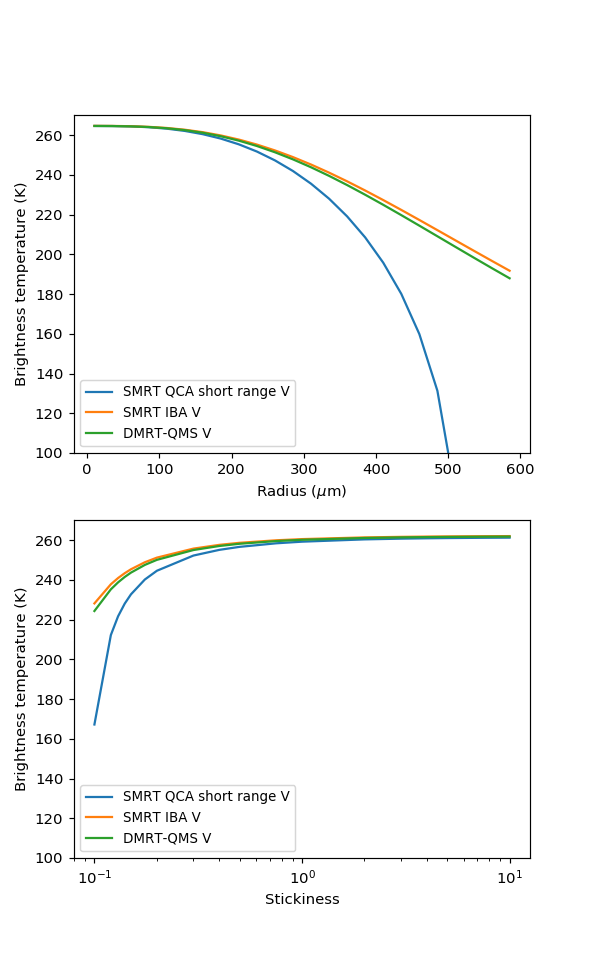

In [3]:
# create the SMRT Model with emmodel="dmrt_qca_shortrange"
m_qca = make_model("dmrt_qca_shortrange", "dort")
# run the model
res_qca_radius = m_qca.run(radiometer, snowpacks_radius[radius<530])  # [:len(radius_qca)]

# create the SMRT Model with emmodel="iba"
m_iba = make_model("iba", "dort")
# run the model
res_iba_radius = m_iba.run(radiometer, snowpacks_radius)

# plots
f, axs =  plt.subplots(2, 1, figsize=(5.5,9))
axs[0].plot(res_qca_radius.coords['radius'], res_qca_radius.TbV(), label='SMRT QCA short range V', color=color[0])
axs[0].plot(res_iba_radius.coords['radius'], res_iba_radius.TbV(), label='SMRT IBA V', color=color[1])

axs[0].set_xlabel('Radius ($\mu$m)')
axs[0].set_ylabel ('Brightness temperature (K)')
axs[0].legend(loc='best')
axs[0].set_ylim((100, 270))


res_qca_stickiness = m_qca.run(radiometer, snowpacks_stickiness)
res_iba_stickiness = m_iba.run(radiometer, snowpacks_stickiness)

# plots
axs[1].semilogx(res_qca_stickiness.coords['stickiness'], res_qca_stickiness.TbV(), label='SMRT QCA short range V', color=color[0])
axs[1].semilogx(res_iba_stickiness.coords['stickiness'], res_iba_stickiness.TbV(), label='SMRT IBA V', color=color[1])

axs[1].set_xlabel('Stickiness')
axs[1].set_ylabel ('Brightness temperature (K)')
axs[1].legend(loc='best')
axs[1].set_ylim((100, 270));

In [4]:
# run DMRT-QMS in passive mode
cache_file = "res_qms_radius_sensitivity.nc"

if os.path.exists(cache_file):
    res_qms = open_result(cache_file)
    
elif have_dmrtqms:
    res_qms = dmrt_qms_legacy.run(radiometer, snowpacks_radius)
    
    res_qms.save(cache_file)
else:
    res_qms = None

if res_qms:
    axs[0].plot(radius, res_qms.TbV(), label='DMRT-QMS V', color=color[2])


def get_limit(res_x, res_ref, threshold):
    err = abs(res_x.TbV()-res_ref.TbV())>threshold
    return np.argmax(err) if any(err) else -1
    

print("1K error: ", radius[get_limit(res_qca_radius, res_qms, 1)])
print("5K error: ", radius[get_limit(res_qca_radius, res_qms, 5)])

print("1K error: ", radius[get_limit(res_iba_radius, res_qms, 1)])
print("5K error: ", radius[get_limit(res_iba_radius, res_qms, 5)])




1K error:  185
5K error:  285
1K error:  285
5K error:  585


In [5]:
cache_file = "res_qms_stickiness_sensitivity.nc"

if os.path.exists(cache_file):
    res_qms = open_result(cache_file)
    
elif have_dmrtqms:
    res_qms = dmrt_qms_legacy.run(radiometer, snowpacks_stickiness)
    
    res_qms.save(cache_file)
else:
    res_qms = None

if res_qms:
    axs[1].plot(res_qms.coords['stickiness'], res_qms.TbV(), label='DMRT-QMS V', color=color[2])
    
def get_limit(res_x, res_ref, threshold):
    err = np.array(abs(res_x.TbV()-res_ref.TbV())>threshold)
    err = np.flip(err, 0)
    return -np.argmax(err) if any(err) else -1
    
    
print("1K error: ", stickiness[get_limit(res_qca_stickiness, res_qms, 1)])
print("5K error: ", stickiness[get_limit(res_qca_stickiness, res_qms, 5)])

print("1K error: ", stickiness[get_limit(res_iba_stickiness, res_qms, 1)])
print("5K error: ", stickiness[get_limit(res_iba_stickiness, res_qms, 5)])

1K error:  1.0
5K error:  0.3
1K error:  0.3
5K error:  10.0


In [6]:
for ax in axs: ax.legend(loc='best', prop={'size': 9})
#f.savefig("fig_smrt_short_range_limitation.pdf")